<a href="https://colab.research.google.com/github/Nilufaraliya/Descriptive-stats-in-R/blob/main/Recommendation_System_Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation system Book

In [ ]:
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [ ]:
books = pd.read_csv(r"https://raw.githubusercontent.com/ashima96/Book-Recommendation-System/master/Datasets/Books.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
users = pd.read_csv(r"https://raw.githubusercontent.com/ashima96/Book-Recommendation-System/master/Datasets/Users.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)
ratings = pd.read_csv(r"https://raw.githubusercontent.com/ashima96/Book-Recommendation-System/master/Datasets/Book-Ratings.csv", delimiter=';', error_bad_lines=False, encoding='ISO-8859-1', warn_bad_lines=False)

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


Pre Processing

In [ ]:
print("Columns: ", list(books.columns))
books.head()

Columns:  ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
## Drop URL columns
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [ ]:
## Checking for null values
books.isnull().sum() 

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [ ]:
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [ ]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [ ]:
books.at[187689 ,'Book-Author'] = 'Other'

books.at[128890 ,'Publisher'] = 'Other'
books.at[129037 ,'Publisher'] = 'Other'

In [ ]:
## Checking for column Year-of-publication
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [ ]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [ ]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [ ]:
books.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books.at[209538 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books.at[221678 ,'Year-Of-Publication'] = 2000
books.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'
books.at[209538 ,'Book-Author'] = 'James Buckley'

books.at[220731 ,'Publisher'] = 'Gallimard'
books.at[220731 ,'Year-Of-Publication'] = '2003'
books.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [ ]:
## Converting year of publication in Numbers
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [ ]:
print(sorted(list(books['Year-Of-Publication'].unique())))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [ ]:
## Replacing Invalid years with max year
count = Counter(books['Year-Of-Publication'])
[k for k, v in count.items() if v == max(count.values())]

[2002]

In [ ]:
books.loc[books['Year-Of-Publication'] > 2021, 'Year-Of-Publication'] = 2002
books.loc[books['Year-Of-Publication'] == 0, 'Year-Of-Publication'] = 2002

In [ ]:
## Uppercasing all alphabets in ISBN
books['ISBN'] = books['ISBN'].str.upper()

In [ ]:
## Drop duplicate rows
books.drop_duplicates(keep='last', inplace=True) 
books.reset_index(drop = True, inplace = True)

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271047 entries, 0 to 271046
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271047 non-null  object
 1   Book-Title           271047 non-null  object
 2   Book-Author          271047 non-null  object
 3   Year-Of-Publication  271047 non-null  int64 
 4   Publisher            271047 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.3+ MB


In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


Users Dataset Pre-Processing

In [ ]:
print("Columns: ", list(users.columns))
users.head()

Columns:  ['User-ID', 'Location', 'Age']


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
print(users.isna().sum())

User-ID     0     
Location    0     
Age         110762
dtype: int64


In [ ]:
## Check for all values present in Age column
print(sorted(list(users['Age'].unique())))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [ ]:
required = users[users['Age'] <= 80]
required = required[required['Age'] >= 10]

In [ ]:
mean = round(required['Age'].mean())   
mean

35

In [ ]:
users.loc[users['Age'] > 80, 'Age'] = mean    #outliers with age grater than 80 are substituted with mean 
users.loc[users['Age'] < 10, 'Age'] = mean    #outliers with age less than 10 years are substitued with mean
users['Age'] = users['Age'].fillna(mean)      #filling null values with mean
users['Age'] = users['Age'].astype(int)       #changing Datatype to int

In [ ]:
list_ = users.Location.str.split(', ')

city = []
state = []
country = []
count_no_state = 0    
count_no_country = 0

for i in range(0,len(list_)):
    if list_[i][0] == ' ' or list_[i][0] == '' or list_[i][0]=='n/a' or list_[i][0] == ',':  #removing invalid entries too
        city.append('other')
    else:
        city.append(list_[i][0].lower())

    if(len(list_[i])<2):
        state.append('other')
        country.append('other')
        count_no_state += 1
        count_no_country += 1
    else:
        if list_[i][1] == ' ' or list_[i][1] == '' or list_[i][1]=='n/a' or list_[i][1] == ',':   #removing invalid entries 
            state.append('other')
            count_no_state += 1            
        else:
            state.append(list_[i][1].lower())
        
        if(len(list_[i])<3):
            country.append('other')
            count_no_country += 1
        else:
            if list_[i][2] == ''or list_[i][1] == ',' or list_[i][2] == ' ' or list_[i][2] == 'n/a':
                country.append('other')
                count_no_country += 1
            else:
                country.append(list_[i][2].lower())
        
users = users.drop('Location',axis=1)

temp = []
for ent in city:
    c = ent.split('/')            #handling cases where city/state entries from city list as state is already given 
    temp.append(c[0])

df_city = pd.DataFrame(temp,columns=['City'])
df_state = pd.DataFrame(state,columns=['State'])
df_country = pd.DataFrame(country,columns=['Country'])

users = pd.concat([users, df_city], axis=1)
users = pd.concat([users, df_state], axis=1)
users = pd.concat([users, df_country], axis=1)

print(count_no_country)   #printing the number of countries didnt have any values 
print(count_no_state)     #printing the states which didnt have any values

4659
16044


In [ ]:
## Drop duplicate rows
users.drop_duplicates(keep='last', inplace=True)
users.reset_index(drop=True, inplace=True)

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   User-ID  278858 non-null  int64 
 1   Age      278858 non-null  int64 
 2   City     278858 non-null  object
 3   State    278858 non-null  object
 4   Country  278858 non-null  object
dtypes: int64(2), object(3)
memory usage: 10.6+ MB


In [ ]:
users.head()

,User-ID,Age,City,State,Country
0,1,35,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,35,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,35,farnborough,hants,united kingdom


In [ ]:
print("Columns: ", list(ratings.columns))
ratings.head()

Columns:  ['User-ID', 'ISBN', 'Book-Rating']


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
## Checking for null values
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [ ]:
## checking all ratings number or not
print(is_numeric_dtype(ratings['Book-Rating']))


True


In [ ]:
## checking User-ID contains only number or not
print(is_numeric_dtype(ratings['User-ID']))

True


In [ ]:
## checking ISBN
flag = 0
k =[]
reg = "[^A-Za-z0-9]"

for x in ratings['ISBN']:
    z = re.search(reg,x)    
    if z:
        flag = 1

if flag == 1:
    print("False")
else:
    print("True")
    

False


In [ ]:
## removing extra characters from ISBN (from ratings dataset) existing in books dataset
bookISBN = books['ISBN'].tolist() 
reg = "[^A-Za-z0-9]" 
for index, row_Value in ratings.iterrows():
    z = re.search(reg, row_Value['ISBN'])    
    if z:
        f = re.sub(reg,"",row_Value['ISBN'])
        if f in bookISBN:
            ratings.at[index , 'ISBN'] = f

In [ ]:
## Uppercasing all alphabets in ISBN
ratings['ISBN'] = ratings['ISBN'].str.upper()

In [ ]:
## Drop duplicate rows
ratings.drop_duplicates(keep='last', inplace=True)
ratings.reset_index(drop=True, inplace=True)

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149776 entries, 0 to 1149775
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149776 non-null  int64 
 1   ISBN         1149776 non-null  object
 2   Book-Rating  1149776 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Merging of all three Tables

In [ ]:
dataset = pd.merge(books, ratings, on='ISBN', how='inner')
dataset = pd.merge(dataset, users, on='User-ID', how='inner')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031609 entries, 0 to 1031608
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   ISBN                 1031609 non-null  object
 1   Book-Title           1031609 non-null  object
 2   Book-Author          1031609 non-null  object
 3   Year-Of-Publication  1031609 non-null  int64 
 4   Publisher            1031609 non-null  object
 5   User-ID              1031609 non-null  int64 
 6   Book-Rating          1031609 non-null  int64 
 7   Age                  1031609 non-null  int64 
 8   City                 1031609 non-null  object
 9   State                1031609 non-null  object
 10  Country              1031609 non-null  object
dtypes: int64(4), object(7)
memory usage: 94.4+ MB


In [ ]:
## Explicit Ratings Dataset
dataset1 = dataset[dataset['Book-Rating'] != 0]
dataset1 = dataset1.reset_index(drop = True)
dataset1.shape

(384074, 11)

In [ ]:
## Implicit Ratings Dataset
dataset2 = dataset[dataset['Book-Rating'] == 0]
dataset2 = dataset2.reset_index(drop = True)
dataset2.shape

(647535, 11)

In [ ]:
dataset1.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,City,State,Country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35,timmins,ontario,canada


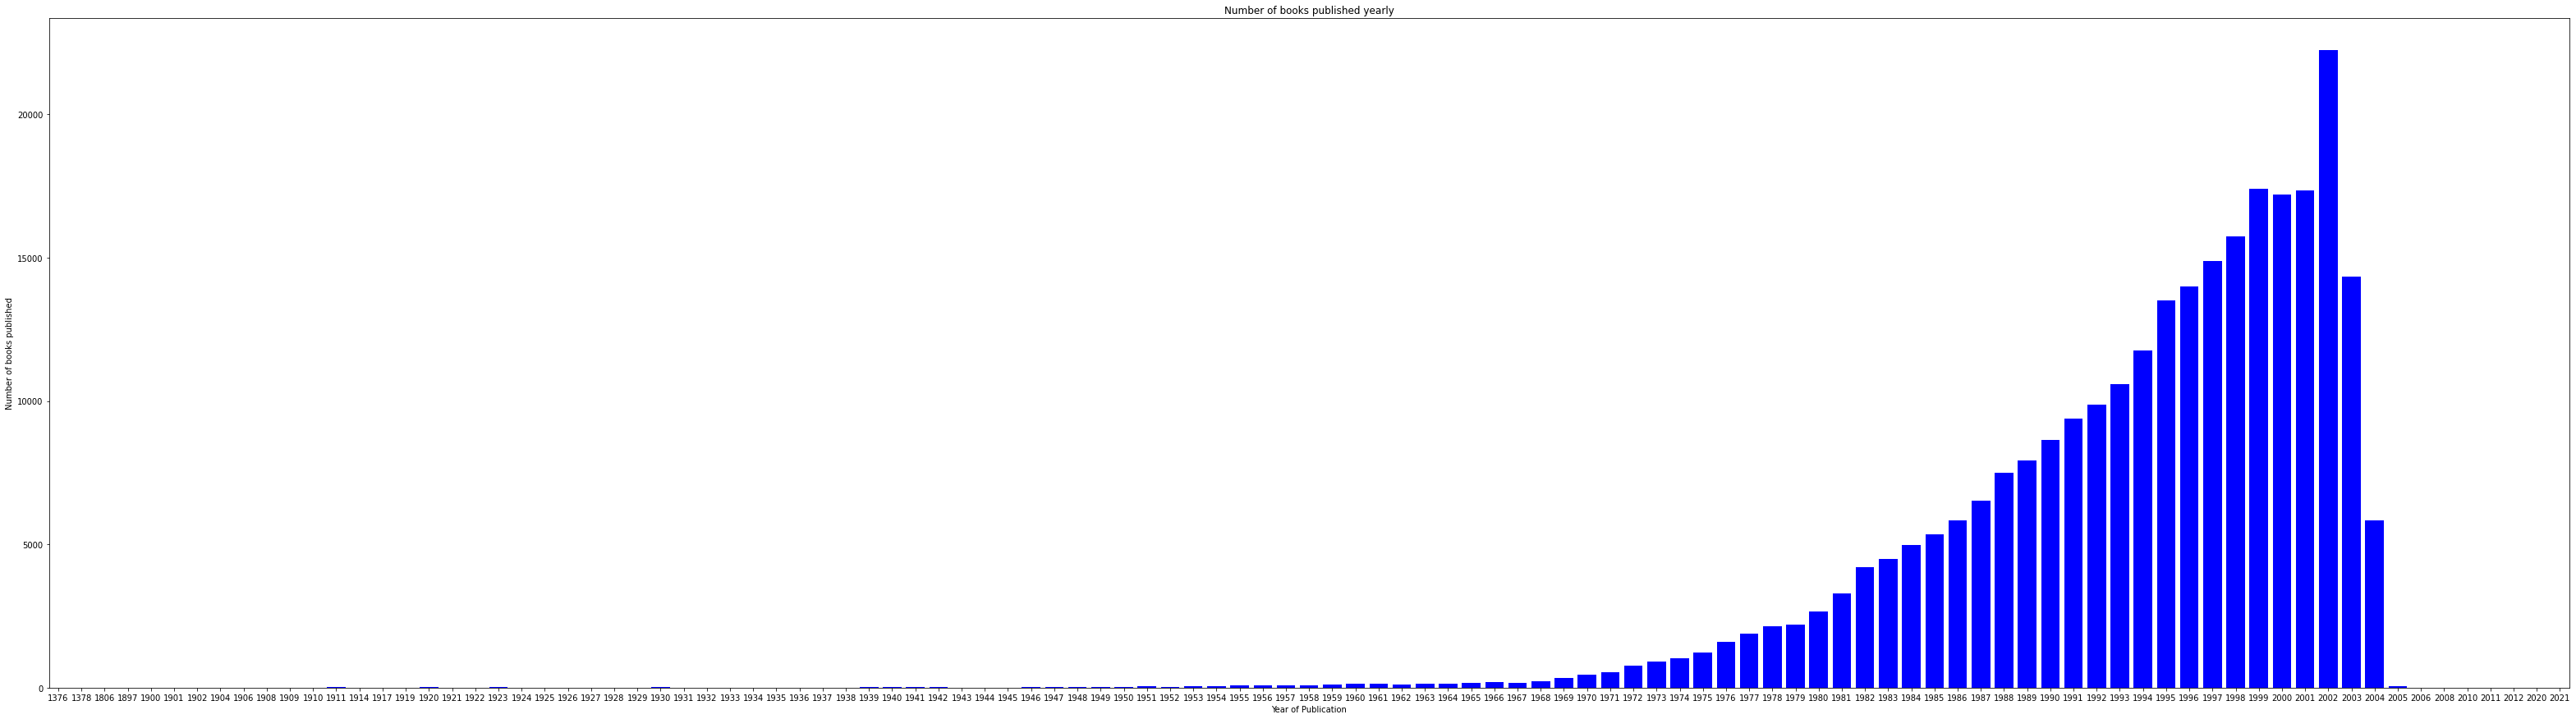

In [ ]:
publications = {}
for year in books['Year-Of-Publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.show()

Text(0.5, 1.0, 'No of books by an author (Top 15)')

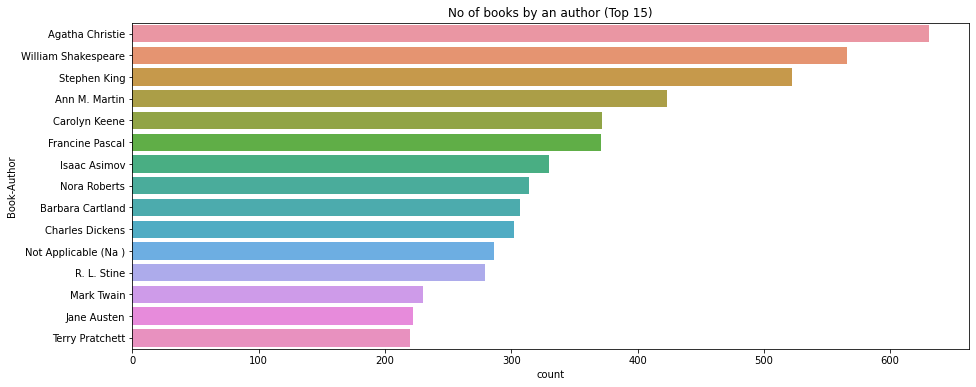

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books,order=books['Book-Author'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

Text(0.5, 1.0, 'No of books published by a publisher (Top 15)')

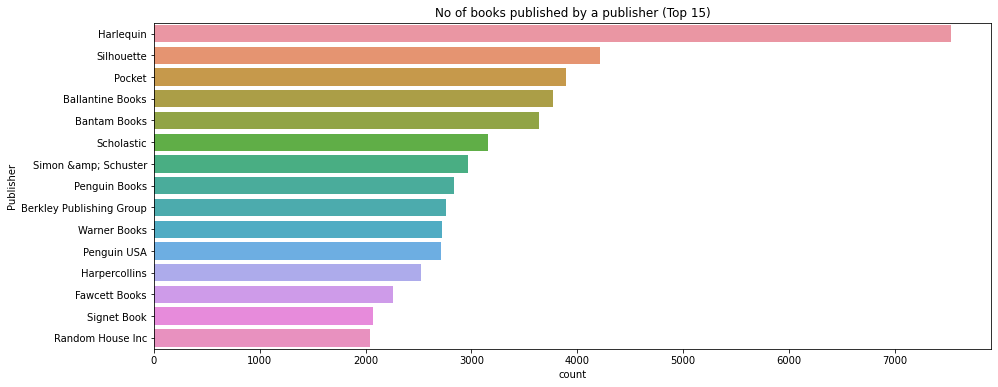

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(y="Publisher", data=books,order=books['Publisher'].value_counts().index[0:15])
plt.title("No of books published by a publisher (Top 15)")

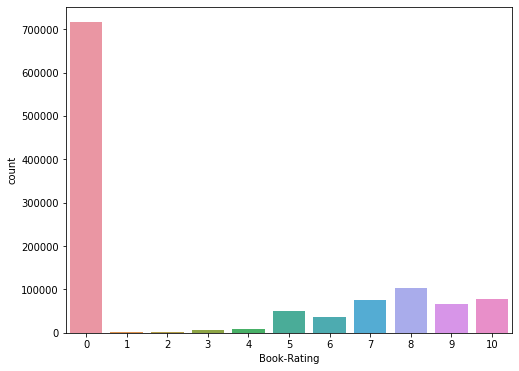

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

Text(0.5, 1.0, 'Explicit Ratings')

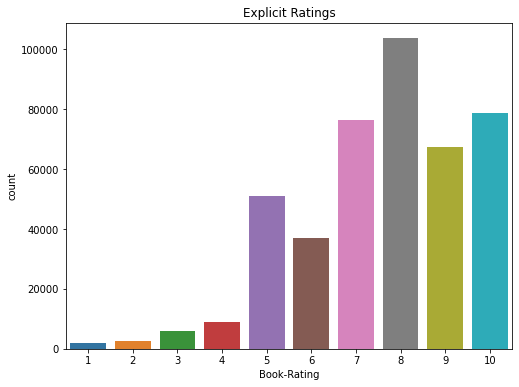

In [ ]:
## Explicit Ratings
plt.figure(figsize=(8,6))
data = ratings[ratings['Book-Rating'] != 0]
sns.countplot(x="Book-Rating", data=data)
plt.title("Explicit Ratings")

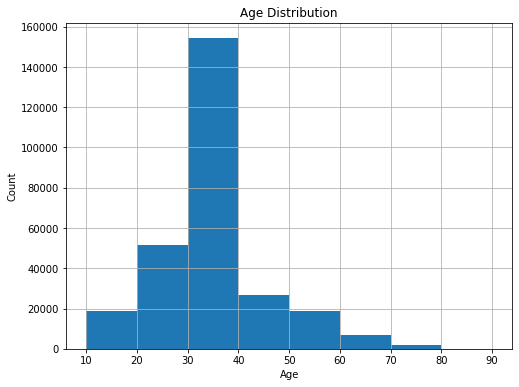

In [ ]:
plt.figure(figsize=(8,6))
users.Age.hist(bins=[10*i for i in range(1, 10)])     
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'No of readers from each city (Top 15)')

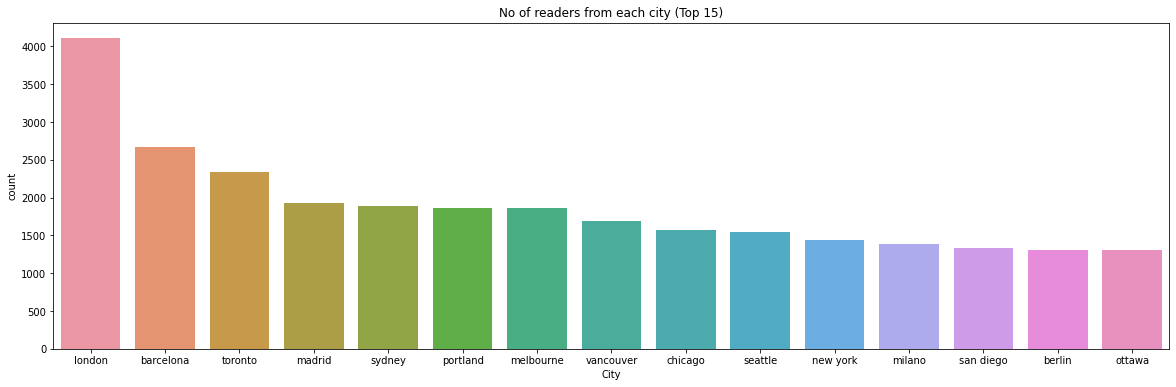

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(x="City", data=users,order=users['City'].value_counts().index[0:15])
plt.title("No of readers from each city (Top 15)")

Text(0.5, 1.0, 'No of readers from each state (Top 15)')

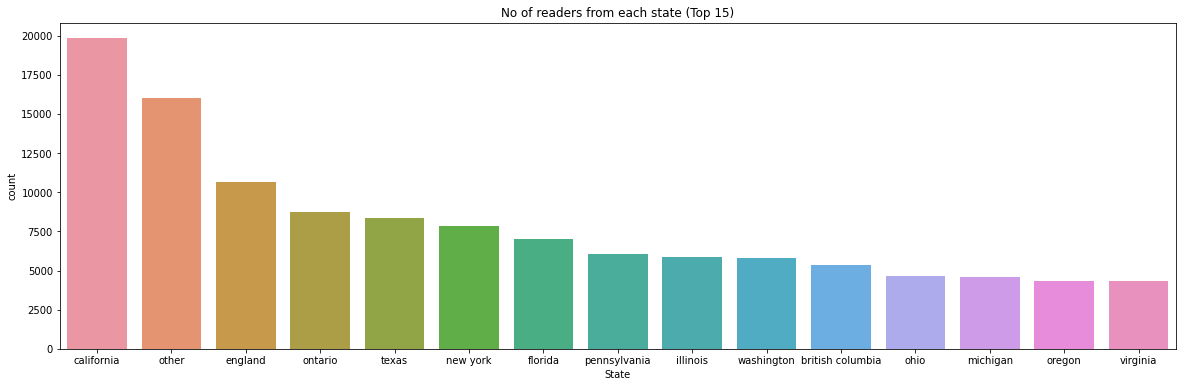

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=users,order=users['State'].value_counts().index[0:15])
plt.title("No of readers from each state (Top 15)")

Text(0.5, 1.0, 'No of readers from each country (Top 10)')

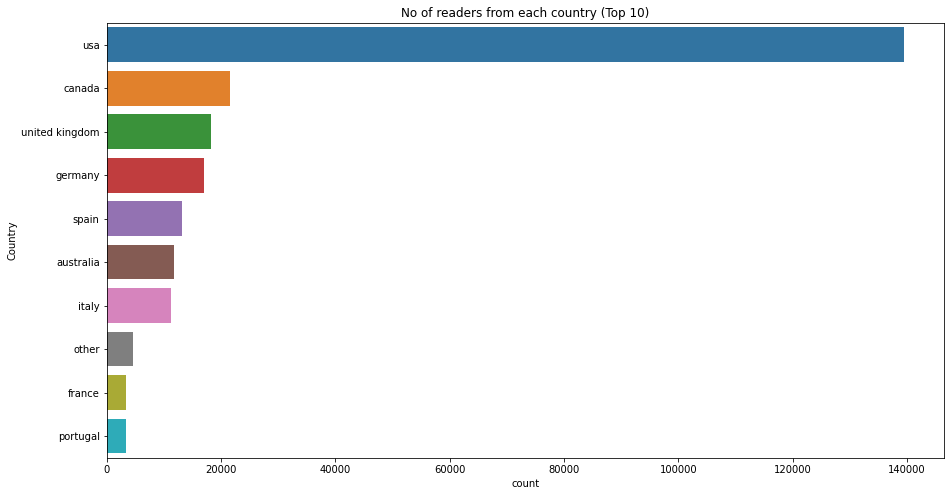

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="Country", data=users, order=users['Country'].value_counts().index[0:10])
plt.title("No of readers from each country (Top 10)")

Text(0.5, 1.0, 'No of readers from states of USA (Top 15)')

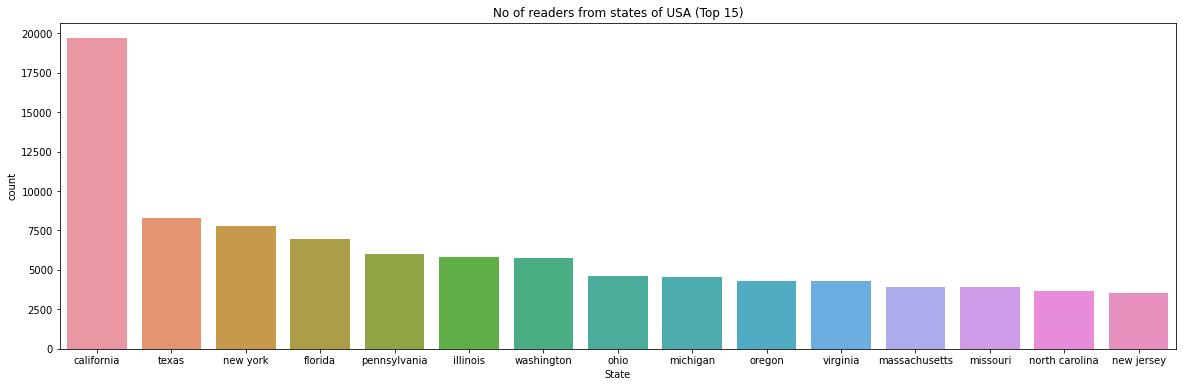

In [ ]:
data=users[users['Country']=='usa']
plt.figure(figsize=(20,6))
sns.countplot(x="State", data=data,order=data['State'].value_counts().index[0:15])
plt.title("No of readers from states of USA (Top 15)")

Text(0.5, 1.0, 'Number of Ratings for a book (Top 15)')

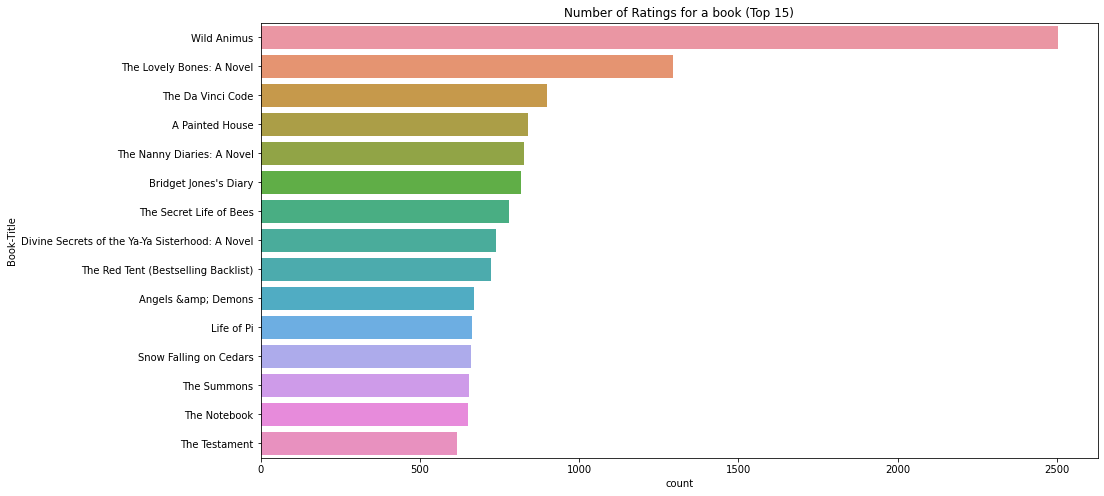

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y="Book-Title", data=dataset, order=dataset['Book-Title'].value_counts().index[0:15])
plt.title("Number of Ratings for a book (Top 15)")

# Recommendation System

In [ ]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Enter number of books to recommend: 5


In [ ]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
        result = pd.merge(data, books, on='ISBN', left_index = True)
        return result
    return "Invalid number of books entered!!"

In [ ]:
def search_unique_places(dataframe, place):
    place = place.lower()

    if place in list(dataframe['City'].unique()):
        return dataframe[dataframe['City'] == place]
    elif place in list(dataframe['State'].unique()):
        return dataframe[dataframe['State'] == place]
    elif place in list(dataframe['Country'].unique()):
        return dataframe[dataframe['Country'] == place]
    else:
        return "Invalid Entry"

In [ ]:
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [ ]:
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = dataset1[dataset1['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating']) 
    printBook(k2, n)

In [ ]:
if bookName in list(dataset1['Book-Title'].unique()):
    d = dataset1[dataset1['Book-Title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")


Books by same Author:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter y el cÃ¡liz de fuego
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Sorcerer's Stone (Book 1)


Books by same Publisher:

The Seeing Stone
The Slightly True Story of Cedar B. Hartley: Who Planned to Live an Unusual Life
Harry Potter and the Chamber of Secrets (Harry Potter)
The Story of the Seagull and the Cat Who Taught Her To Fly
Book! Book! Book!


In [ ]:
df = pd.DataFrame(dataset1['Book-Title'].value_counts())
df['Total-Ratings'] = df['Book-Title']
df['Book-Title'] = df.index
df.reset_index(level=0, inplace=True)
df = df.drop('index',axis=1)

df = dataset1.merge(df, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
df = df.drop(['Year-Of-Publication','Publisher','Age','City','State','Country'], axis=1)

popularity_threshold = 50
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

In [ ]:
testdf = pd.DataFrame()
testdf['ISBN'] = popular_book['ISBN']
testdf['Book-Rating'] = popular_book['Book-Rating']
testdf['User-ID'] = popular_book['User-ID']
testdf = testdf[['User-ID','Book-Rating']].groupby(testdf['ISBN'])

In [ ]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)

In [ ]:
def printBookDetails(bookID):
    print(dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    """
    print("Title:", dataset1[dataset1['ISBN']==bookID]['Book-Title'].values[0])
    print("Author:",dataset1[dataset['ISBN']==bookID]['Book-Author'].values[0])
    #print("Printing Book-ID:",bookID)
    print("\n")
    """

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)
    
    print("\nRECOMMENDATIONS:\n")
    
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset1[dataset1['ISBN']==indexMap[i]]['Book-Title'].values[0])
    return collaborative

In [ ]:
k = list(dataset1['Book-Title'])
m = list(dataset1['ISBN'])

collaborative = getTopRecommandations(m[k.index(bookName)])

Input Book:
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

RECOMMENDATIONS:

Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Chamber of Secrets (Book 2)
Fried Green Tomatoes at the Whistle Stop Cafe


Correlation Based

In [ ]:
popularity_threshold = 50

user_count = dataset1['User-ID'].value_counts()
data = dataset1[dataset1['User-ID'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['Book-Rating'].value_counts()
data = data[data['Book-Rating'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='User-ID', columns='ISBN', values = 'Book-Rating').fillna(0)

In [ ]:
average_rating = pd.DataFrame(dataset1.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0971880107,4.390706,2502
0316666343,8.185290,1295
0385504209,8.426230,884
0060928336,7.887500,732
0312195516,8.182768,723


In [ ]:
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(number+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['ISBN']), books, on='ISBN')
print("\n Recommended Books: \n")
corr_books


 Recommended Books: 



,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic
1,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,Scholastic
2,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic
3,0804115613,Fried Green Tomatoes at the Whistle Stop Cafe,Fannie Flagg,2000,Ballantine Books
4,0439139600,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2002,Scholastic Paperbacks


Nearest Neighbours Based

In [ ]:
popularity_threshold = 80
popular_book = df[df['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(44652, 6)

In [ ]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(44652, 1112)

In [ ]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(44652, 44652)

In [ ]:
print("Recommended Books:\n")
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Recommended Books:

Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Order of the Phoenix (Book 5)


Hybrid Approach

In [ ]:
z = list()
k = float(1/number)
for x in range(number):
      z.append(1-k*x)

dictISBN = {}
for x in collaborative:
      dictISBN[x] = z[collaborative.index(x)]

for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]

ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))
w=0
print("Input Book:\n")
print(bookName)
print("\nRecommended Books:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Input Book:

Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Recommended Books:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Order of the Phoenix (Book 5)
